In [257]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
from graphStructure import graph 
from structure import node

In [258]:
#Read data of sensors
sensorData = pd.read_excel('Data/Environement/K=12/SensorInformation.xls')
sensorCoordinate = []

In [259]:
#Sensors coordinate 
for row in sensorData.index:
    coordinate = (sensorData['X'][row] ,sensorData['Y'][row] ,sensorData['Cluster_Index'][row])
    sensorCoordinate.append(coordinate)
sensorInformations = sensorCoordinate 

In [260]:
#Cluster Information 
clusterData = pd.read_excel('Data/Environement/K=12/ClustersInformations.xls')
ClusterInformation = []
AllClusterIndex = []

In [261]:
#Cluster coordinate 
for row in clusterData.index:
    coordinate = (clusterData['X'][row] ,clusterData['Y'][row] , clusterData['Cluster_index'][row])
    ClusterInformation.append(coordinate)
    AllClusterIndex.append(clusterData['Cluster_index'][row])
C= AllClusterIndex[0:-1]
#Create a graph structure 
predecessor = []
sucessor =[]
Nodesss = []
for i in range(len(AllClusterIndex)):
    predecessor = []
    sucessor =[]
    for j in range(len(AllClusterIndex)):
        if i==len(AllClusterIndex)-1 and i!=j:
            sucessor.append(j)
        if i!=j and j != len(AllClusterIndex)-1 and i!= len(AllClusterIndex)-1 :
            predecessor.append(j)
            sucessor.append(j)
    g = graph(i , predecessor , sucessor)
    Nodesss.append(g)
N = node(Nodesss)
AllClusterIndex
# Normlized Data of the Mission 
nomlizedMissionData = pd.read_excel("NormlizedData.xls")
missionInformationSubPath = []
missionInformationScores =  []
for row in nomlizedMissionData.index:
    subPath = (nomlizedMissionData['Cluster_ID'][row] , nomlizedMissionData['Cluster_DESTINATION'][row])
    scores  =(float(nomlizedMissionData['TIME_TRAVEL_CONSUMPTION'][row]),float(nomlizedMissionData['HOVERING_TIME'][row]) , float(nomlizedMissionData['ENERGY_HOVER'][row])  , float(nomlizedMissionData['TRAVEL_ENERGY_COST'][row]))
    missionInformationSubPath.append(subPath)
    missionInformationScores.append(scores)

In [262]:
C

[0, 1, 2]

In [263]:
N.getpredecessors(2)

[0, 1]

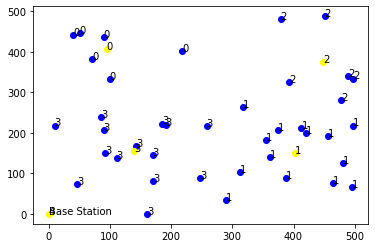

<Figure size 1440x1440 with 0 Axes>

In [25]:
for coor in sensorInformations:
    plt.scatter(coor[0] , coor[1] , c = 'blue')
    plt.text(coor[0] , coor[1] , coor[2])
for coor in ClusterInformation:
    if coor[0] == 0 and coor[1] == 0:
        plt.text(0 , 0 , 'Base Station')
    plt.scatter(coor[0] , coor[1] , c = 'yellow' )
    plt.text(coor[0] , coor[1]  , coor[2])
plt.figure(figsize=(20,20))
plt.show()

In [265]:
# Starting with gurobi , Match subpath with there scores 
import gurobipy as gp 
from gurobipy import GRB 
dataDict = {}
for cluster in range(len(missionInformationSubPath)):
    dataDict.update({missionInformationSubPath[cluster] : missionInformationScores[cluster]})

In [266]:
#Match subpath with there scores  
combinations , timeTravel , hoveringTime , energyTravel , hoveringEnergy  = gp.multidict(dataDict)

In [267]:
numberOfCluster = 5

In [268]:
# The decision variable of the subPath it's equal to 1 if the cluster i is connected with the cluster j 
#Initialization of the model 
model  = gp.Model('UAV_TimeEnergy_Minimization')

In [269]:
# Create the decision variable for the UAV_TimeEnergy_Minimization 
# combinations contain the cluster i and the cluster j i--j or a subPath 
x = model.addVars(combinations , vtype = GRB.BINARY , name='SubPath')
TimeTravel = model.addVars(timeTravel , vtype = GRB.CONTINUOUS ,name = 'timeTravel')
HoveringTime =  model.addVars(hoveringTime , vtype = GRB.CONTINUOUS ,name = 'hoveringTime')
EnergyTravel =  model.addVars(energyTravel , vtype = GRB.CONTINUOUS ,name = 'energyTravel')
HoveringEnergy = model.addVars(hoveringEnergy , vtype = GRB.CONTINUOUS ,name = 'hoveringEnergy')

In [270]:
#The startingPosition Should be the base station  (C1) --> keep  
startingPosition = 3

In [271]:
import random 
Lambda  = random.uniform(0,1)

In [272]:
C

[0, 1, 2]

In [273]:
print("λ : ",Lambda , '|1-λ' , 1-Lambda)

λ :  0.13960370256494492 |1-λ 0.8603962974350551


In [274]:
listOfCluster = []
clusterIndex=0 
for element in range(len(x)): 
    listOfCluster.append(clusterIndex)
    clusterIndex+=1
visitedCluster = {3}

In [275]:
#Define the objective function
import random 
from gurobipy import quicksum 
# λ1  = random.uniform(0,1)
# λ2  = 1 - λ1  
# model.NumObj = 2 
# model.modelSense = GRB.MINIMIZE
# model.setObjectiveN(quicksum(TimeTravel[i,j] + HoveringTime[i,j] for  i,j in x) , index=0 , weight = 0.7)
# model.setObjectiveN(quicksum(EnergyTravel[i,j] + HoveringEnergy[i,j] for i,j in x) , index=1 , weight = 0.3 )
model.setObjective(0.2 * quicksum(TimeTravel[i,j] + HoveringTime[i,j] for  i,j in x) + 0.8 * quicksum(EnergyTravel[i,j] + HoveringEnergy[i,j] for i,j in x)  , GRB.MINIMIZE)
model.update()

In [230]:
for i in range(numberOfCluster):
    model.addConstr(quicksum(x[i,j] for j in range(numberOfCluster) if i!=j and j!= startingPosition ) == 1 , name="out_%d" % i)
    model.addConstr(quicksum(x[j,i] for j in range(numberOfCluster) if i!=j and i!= startingPosition ) == 1, name="in_%d" % i)

In [231]:
def add_subtour_elimination_constraints(model , n , x):
     # Create an empty list to store the subtour elimination constraints
    subtour_constraints  = []
    for i in range(1,n):
        for j in range(i+1 , n):
            subtour_constraints.append(model.addConstr(
                quicksum(x[i , k] for k in range(n) if k != i)+
                quicksum(x[k , j] for k in range(n) if k!= j )<=
                quicksum(x[i,j] for i in range(n)) - 1, "subtour_" + str(i) + "_" + str(j)))
    return subtour_constraints

In [ ]:
#N.getpredecessors(startingPosition)

quicksum(x[startingPosition,j] for j in N.getsucessors(startingPosition))

In [276]:
#Constraint leave the starting position once  OK
model.addConstr( quicksum(x[j,startingPosition] for j in N.getpredecessors(startingPosition)) - quicksum(x[startingPosition,j] for j in N.getsucessors(startingPosition)) == -1 )
# First visited is the starting position 
#model.addConstr(quicksum(x[startingPosition,j] for j in C) == 1 , name="start_%d" % j)
endingPosition = C[-1] # assuming the last cluster in the list is the ending position
model.addConstr(quicksum(x[i,endingPosition] for i in C if i != endingPosition) == 0 , name="no_back_to_end")
# Incoming edges + outcoming edges = 0 
#model.addConstrs(quicksum(x[i,j] for j in N.getsucessors(i)) - quicksum(x[j,i] for j in N.getpredecessors(i)) == 0 for i in C )

#enter  each cluster once 
model.addConstrs(quicksum(x[i,j] for i in N.getpredecessors(j)) == 1 for j in C)
# leave each cluster once  
model.addConstrs(quicksum(x[i,j] for j in N.getsucessors(i)) ==1 for i in C)
model.update()

In [277]:
# pour une ligne droite le model n'arrive pas a trouvé une solution 

In [278]:
model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 11 rows, 45 columns and 29 nonzeros
Model fingerprint: 0xf585e660
Variable types: 36 continuous, 9 integer (9 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1 rows and 39 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -


In [255]:
active_arcs = [ i for i in x if x[i].x>0.99]

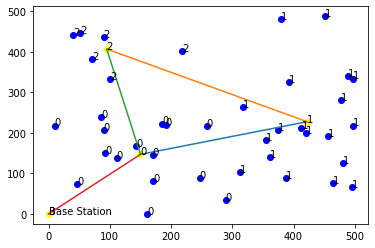

[(0, 1), (1, 2), (2, 0), (3, 0)]


<Figure size 432x288 with 0 Axes>

In [256]:

def getCoordinateFromClusterIndex(index):
    for coor in ClusterInformation:
        if coor[2] == index:
            return [coor[0] , coor[1]]
    
active_arcs 
for coor in sensorInformations:
    plt.scatter(coor[0] , coor[1] , c = 'blue')
    plt.text(coor[0] , coor[1] , coor[2])
for coor in ClusterInformation:
    if coor[0] == 0 and coor[1] == 0:
        plt.text(0 , 0 , 'Base Station')
    plt.scatter(coor[0] , coor[1] , c = 'yellow' )
    plt.text(coor[0] , coor[1]  , coor[2])
for subPath in active_arcs:
    cor1 = getCoordinateFromClusterIndex(subPath[0])
    cor2 = getCoordinateFromClusterIndex(subPath[1])
    X = [cor1[0] , cor2[0]] 
    Y = [cor1[1] , cor2[1]]
    plt.plot(X , Y)
plt.show()
#Print the subPath
plt.show()
print(active_arcs)
plt.savefig('solverPath.png')

In [ ]:
edges = []
for edge in missionInformationSubPath:
    edges.append(edge)
edges = tuple(edges)
print(edges)

In [181]:
allNodes = [i for i in range(0 , numberOfCluster)]
allNodes = tuple(allNodes)
print(allNodes)

t = {}
for i in range(numberOfCluster):
    for j in range(numberOfCluster):
        t[i, j] = model.addVar(vtype=GRB.BINARY, lb=0, ub=1, name="t_%d_%d" % (i, j))

model.update()

(0, 1, 2, 3)


In [182]:
model.update()

In [ ]:
# Add the Miller-Tucker-Zemlin variables and constraints and resolve 
u = model.addVars(allNodes)
model.update()
# (i , j) in tour => u[j] >= u[i] +1 
#EX : assume start at node 0 
model.addConstrs(u[i] - u[j] + (numberOfCluster*x[i , j]) <= numberOfCluster-1 for i,j in edges if j!= startingPosition)
model.optimize()

In [ ]:
active_arcs = [ i for i in x if x[i].x>0.99]

In [ ]:
active_arcs